Libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

from nltk.stem.wordnet import WordNetLemmatizer
from spacy.lang.en import English
from googlesearch import search 

from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request

import wikipediaapi
import concurrent.futures
from tqdm import tqdm

import itertools
import collections
import textrank
import textract

from textblob import TextBlob
from nltk.corpus import stopwords 
from heapq import nlargest

import urllib
import requests
import time
import random

import re
import logging
import numpy as np
import pandas as pd
import nltk

from requests import get
from pattern.web import plaintext

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from pprint import pprint as print
from gensim.summarization import summarize
from gensim.summarization import keywords
from gensim.summarization import mz_keywords

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.cluster.util import cosine_distance

import networkx as nx
from collections import OrderedDict
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import spacy

import trkeyword

In [2]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

Disable logging:

In [3]:
import logging, sys
logging.disable(sys.maxsize)

Load parameters:

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nlp = en_core_web_sm.load()
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skamenshchikov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skamenshchikov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

CDFs:

In [5]:
def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('page {} does not exist'.format(topic_name))
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    return sources

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_data = {'page': page_name, 'text': page_name.text, 'link': page_name.fullurl,
                 'categories': [[y[9:] for y in list(page_name.categories.keys())]]}
    page_data_df = pd.DataFrame(page_data)
    return page_data_df

class TextRank4Keyword():
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(round(value,1)))
            if i > number:
                break
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        
def text_summarizer(raw_docx):
    
    raw_text = raw_docx
    docx = nlp(raw_text)
    stopwords = list(STOP_WORDS)

    word_frequencies = {}  
    for word in tqdm(docx):  
        if word.text not in stopwords:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1


    maximum_frequncy = max(word_frequencies.values())

    for word in tqdm(word_frequencies.keys()):  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_list = [ sentence for sentence in docx.sents ]

    # Calculate Sentence Score and Ranking
    sentence_scores = {}  
    for sent in tqdm(sentence_list):  
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if len(sent.text.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word.text.lower()]
                    else:
                        sentence_scores[sent] += word_frequencies[word.text.lower()]

    summary_sentences = nlargest(7, sentence_scores, key=sentence_scores.get)
    final_sentences = [ w.text for w in summary_sentences ]
    summary = ' '.join(final_sentences)

    print(summary)
    
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

### Web page extraction:

Extract from document:

In [6]:
# docxtxt = textract.process('docs/test.docx').decode('utf-8')
# docxtxt = re.sub('[^A-Za-z0-9]+', ' ', docxtxt)

Extract from web page:

In [7]:
url = 'https://medium.com/@sergeykamenshchikov/nlp-for-composition-of-value-tree-d8495534ebd5'
htmlString = get(url).text
webText = plaintext(htmlString)

Extract from wiki:

In [8]:
# request = 'investment portfolio'
# wiki_data = wiki_scrape(request)
# webText = wiki_data['text'].str.cat(sep='.')
# #webText = wiki_data['text'].iloc[0]

# summary = []
# for i in tqdm(wiki_data['text']):
#     summary.append(summarize(i, split=False, ratio=0.1))

# summary = ''.join(summary)
# summary = re.sub('[^A-Za-z0-9.]+', ' ', summary)
# print(summary)

Extract from Google Search:

In [9]:
# txt = []

# exc_number = 0
# agg_number = 0

# query = 'DeepFaceDrawing'
# url_list = list(search(query, num=100, stop=100, pause=1))

# for j in tqdm(url_list):
    
#     agg_number += 1   
#     if agg_number==11:
#         break
    
#     try: 
#         delta = random.randint(1,8)
#         time.sleep(delta) 
#         html = urllib.request.urlopen(j).read()
#         txt.append(text_from_html(html))
#     except:
#         agg_number -= 1
#         exc_number += 1
        
# summ = ''.join(txt)
# webText = re.sub('[^A-Za-z0-9.]+', ' ', summ)

TextRank summary:

In [10]:
summary = summarize(webText, split=False, ratio=0.1)
summary = ''.join(summary)
summary = re.sub('[^A-Za-z0-9.]+', ' ', summary)
print(summary)

('According to Al Mosaiwi single words absolutisms may be used as predictors '
 'of cognitive errors following rumination. Pathological states like '
 'depression correspond to destructive associative schemes specific graph '
 'clusters which trigger ruminative loops. High number of ruminative clusters '
 'may rise up the integral betweennes centrality of graph. Recognition of '
 'ruminative clusters their centers and undelying values are among the goals '
 'of this research. Each group Request Responce is characterized by unique '
 'bigram matrix. Bigram matrix was used as a generator of weighted undirected '
 'graph for interpretation of Big Data by psychologists at glance. Weight of '
 'each node in matrix corresponds to the single word frequency while edge '
 'length is the inverse function of bigram frequency. Nodes are ranged '
 'according to the betweennes centrality and marked at the transformed graph. '
 'Relatively high BC clustering in the test group is validated by Zip s la

Extract keywords:

In [11]:
summary_norm = re.sub('[^A-Za-z0-9.]+', ' ', summary)
tr4w = TextRank4Keyword()
tr4w.analyze(summary_norm, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
tr4w.get_keywords(5)

'clusters - 2.9'
'graph - 2.4'
'Request - 2.1'
'Group - 1.9'
'analysis - 1.8'
'interpretation - 1.8'
'matrix - 1.6'


Word Cloud:

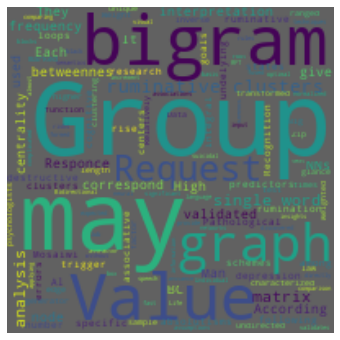

In [12]:
plt.figure(figsize=(6,6))

wordcloud = WordCloud(width=200, height=200, margin=0, background_color='#616161').generate(summary)
wordcloud.to_file('test.png')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

NLP processing:

In [13]:
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(webText.lower())  

filtered_sentence = ' '.join([w for w in word_tokens if not w in stop_words])
filtered_sentence = ' '.join([w for (w, pos) in TextBlob(filtered_sentence).pos_tags if pos[0] == 'N'])

word_list = word_tokenize(filtered_sentence)
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
filtered_sentence = ''.join(lemmatized_output)

tokens = word_tokenize(filtered_sentence)
words = ' '.join([word for word in tokens if word.isalpha()])
text_token=nltk.word_tokenize(words)

bigrams=list(nltk.ngrams(text_token, 2))
bigram_counts = collections.Counter(bigrams)

Generate graph:

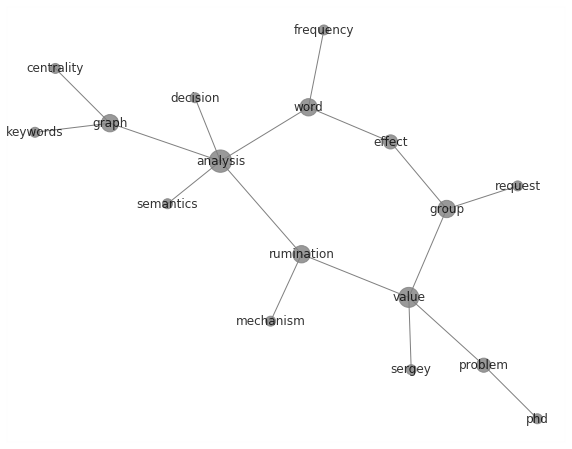

In [14]:
plt.rcParams['axes.linewidth'] = 0.01
fig, ax = plt.subplots(figsize=(10,8))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

d = dict(G.degree)
G.remove_nodes_from(list(nx.isolates(G)))

for i in range(0, 10):
    F = nx.Graph()
    fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > i, G.edges())
    F.add_edges_from(fedges)
    F.remove_nodes_from(list(nx.isolates(F)))
    
    if F.number_of_nodes() < 30:
        break

d = dict(F.degree)        
pos = nx.spring_layout(F, iterations=100)
nx.draw_networkx(F, pos, font_size=12, width=1, edge_color='grey', alpha=0.8, node_color='gray', 
                 with_labels = True, node_size=[v * 100 for v in d.values()], edgelist = [])


nx.draw_networkx_edges(F, pos, width=1, edge_color='grey')

plt.margins(0.05,0.05)
plt.savefig('test.png', bbox_inches="tight")
plt.show()